Done


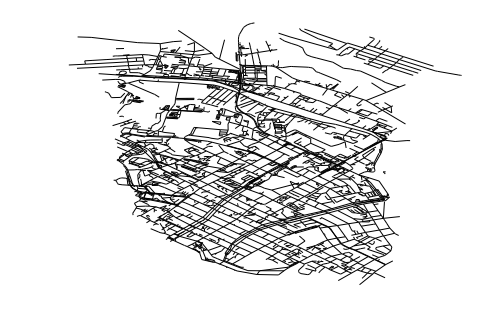

In [4]:
%matplotlib inline
from lxml import etree, objectify
import codecs
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import csv
from math import acos,cos,sin,pi

def getLocations(adList, obj):
    ndLatLon = dict.fromkeys(tuple(adList))   
    for xtag in obj.getchildren():
        if xtag.tag == 'node' and (xtag.attrib.get('id') in adList):
            cor = [float(xtag.attrib.get('lat')),float(xtag.attrib.get('lon'))]
            ndLatLon[xtag.attrib.get('id')] = cor
    return ndLatLon

def deleteUseless(adList, countList, borders):
    for node in adList:
        if len(node)==3 and not(node[0] in borders):#если мы нашли точку, которая не является границей и у неё степень 2,
                                                    #то удаляем
            #соединяем точки, между которыми лежали юзлесноды
            fromNode = countList.index(node[1])
            toNode = countList.index(node[2])
            adList[fromNode].remove(node[0]) 
            adList[toNode].remove(node[0]) 
            adList[fromNode].append(node[2]) 
            adList[toNode].append(node[1])
            #удаляем этот нод
            countList.remove(node[0])
            adList.remove(node)
        elif (len(node)==3 and (node[0] in borders)) or len(node)>3 or len(node)==2:#хорошие точки 
            pass
        else: # рандомные точки(?)
            adList.remove(node)

               
#построение графа
def plotGraph(filename, locs):
    G = nx.read_adjlist(filename)   
    nx.draw(G, pos=locs, node_size = 0, width = 1)
     #nx.draw_networkx(G, pos=locs, node_size = 0, width = 2, with_labels = False)
    plt.axis('off')
    plt.savefig("graph.png", dpi=3000)
    plt.savefig("graph.pdf")
    
#записывает список смежности так, чтоб прочитала либа networkx    
def fileWriter(adList,filename):    
    s = open(filename,"w")
    for item in adList:
        s.write(" ".join(item))
        s.write("\n")
    s.close()

#очередной проход по каждой дороге и добавление всех нодов в о
def costilList(adList, xmlObj, nodesOrder, borders):
    ndList = list()
    try:
        #добавление всех точек дороги в список
        for nd in xmlObj.getchildren():
            if nd.tag == 'nd':
                ndList.append(nd.attrib.get('ref'))
        borders.add(ndList[0])
        borders.add(ndList[-1])
        cd = 0;
        #добавление в список смежности
        while cd<len(ndList)-1:
            fromNode = nodesOrder.index(ndList[cd])
            toNode = nodesOrder.index(ndList[cd+1])
            adList[fromNode].append(ndList[cd+1]) 
            adList[toNode].append(ndList[cd]) 
            cd+=1
    except Exception as e:
        print(e)
        
nodes = set()#множество всех точек лежащих на хайвеях

xml = codecs.open('map.xml', "r", "utf_8_sig" ).read()
root = objectify.fromstring(xml)
#coord=dict()#словарь для координат добавленных вершин
#получаем все ноды на хайвеях из документа
for lul in root.getchildren():
    try:
        #проверка на наличие тега и т.д.
        if lul.tag == 'way' and lul.getchildren()[-1].tag == 'tag' and \
        'highway' in [child.attrib.get('k') for child in lul.getchildren() if child.tag == 'tag']:
            for nd in lul.getchildren():
                if nd.tag == 'nd': 
                    nodes.add(nd.attrib.get('ref'))  
    except AttributeError:
        pass
        #print("errorFirst")

borders = set() #все граничные точки для дорог
countList = list(nodes)#делаем лист(дальше нам понадобится получать индекс нужной точки)
adList = [[x] for x in nodes]#наш основной лист со списком смежности
#мы задаем его так, потому что в списке смежноси для networkx должны быть такие строки "from to to to ... to"

#опять проходимся по документу делая список смежности
for lul in root.getchildren():
    try:
        if lul.tag == 'way' and lul.getchildren()[-1].tag == 'tag' and \
        'highway' in [child.attrib.get('k') for child in lul.getchildren() if child.tag == 'tag']:
            costilList(adList, lul, countList, borders)                   
    except AttributeError:
        pass
        

deleteUseless(adList, countList, borders)
coord = getLocations(countList, root)  #список координат    
#удаляем лишние вершины


filename = "release1.adjlist"
fileWriter(adList, filename)
plotGraph(filename, coord)

#чек на завершение скрипта
print("Done")

In [12]:
from math import sqrt

def plotGraph2(filename, locs, edges, obj, node):
    G = nx.read_adjlist(filename)   
    #nx.draw_networkx(G, pos=locs, node_size = 0, width = 2, with_labels = False)
    nx.draw(G, pos=locs, node_size = 0, width = 1)
    nx.draw_networkx_edges(G, pos=locs, edgelist=edges, width=1, edge_color='r')
    nx.draw_networkx_nodes(G, pos=locs, nodelist=obj, node_color='b', node_size=4) #"особые" точки, в данном случае госпитали
    nx.draw_networkx_nodes(G, pos=locs, nodelist=[edges[0][0]], node_color='g', node_size=4) #вершина где находимся green
    nx.draw_networkx_nodes(G, pos=locs, nodelist=[node], node_color='c', node_size=4) #ближайшая вершина cyan
    plt.axis('off')
    plt.savefig("graph2.png", dpi=3000)
    plt.savefig("graph2.pdf")

def getMatrix(coord, adList, countList): # матрица смежности по списку смежности
    matrix=[[float('inf') for node in countList] for node in countList] 
    for node in adList:
        cur_node_coord = coord[node[0]]
        ind = countList.index(node[0])
        for node1 in node:
            ind1 = countList.index(node1)
            if node1 != node[0]:
                ch_node_coord = coord[node1]
                dist = acos(sin(cur_node_coord[0]*pi/180)*sin(ch_node_coord[0]*pi/180)+cos(cur_node_coord[0]*pi/180) \
                      *cos(ch_node_coord[0]*pi/180)*cos((cur_node_coord[1]-ch_node_coord[1])*pi/180))*6371
                matrix[ind][ind1] = dist;
    return matrix

def Dijkstra(N, S, matrix): #алгоритм Дийкстры, на выходе вектор расстояний до всех точек и массив для восстановления пути
    valid = [True]*N        
    weight = [float('inf')]*N
    weight[S] = 0
    path = [-1]*N
    path[S] = S
    for i in range(N):
        min_weight = float('inf')
        ID_min_weight = -1
        for i in range(len(weight)):
            if valid[i] and weight[i] < min_weight:
                min_weight = weight[i]
                ID_min_weight = i
        for i in range(N):
            if weight[ID_min_weight] + matrix[ID_min_weight][i] < weight[i]:
                weight[i] = weight[ID_min_weight] + matrix[ID_min_weight][i]
                path[i] = ID_min_weight
        valid[ID_min_weight] = False
    return [weight, path]

def Levit(N,S,matrix): #алгоитм Левита
    m2 = [i for i in range(N) if i!=S]
    m1 = [S]
    m0 = list()
    D = [float('inf')]*N
    P = [-1]*N
    D[S] = 0;
    while len(m1) != 0:
        cur = m1.pop(0)
        m0.append(cur)
        edges = [matrix[cur].index(i) for i in matrix[cur] if i<float('inf')]
        for edge in edges:
            if edge in m2:
                m2.remove(edge)
                m1.append(edge)
                D[edge] = D[cur]+matrix[cur][edge]
                P[edge] = cur
            if edge in m1:
                if D[edge] > D[cur] + matrix[cur][edge]:
                    D[edge] = D[cur] + matrix[cur][edge]
                    P[edge] = cur
            if edge in m0:
                 if D[edge] > D[cur] + matrix[cur][edge]:
                        D[edge] = D[cur] + matrix[cur][edge]
                        P[edge] = cur
                        m0.remove(edge)
                        m1.insert(0,edge)
    return [D,P]

def A(start,goal,matrix,coord): #A*
    def h(v):
        return sqrt((coord[goal][0] - coord[countList[v]][0])**2 + (coord[goal][1] - coord[countList[v]][1])**2)
    CS = []
    OS = [start]
    p = [-1]*len(coord)
    g = [float('inf')]*len(coord)
    g[start] = 0
    f = [float('inf')]*len(coord)
    f[start] = g[start] + h(start)
    while len(OS) != 0:
        curr = [i for i in OS if f[i] == min([f[j] for j in OS])]
        curr = curr[0]
        if curr == countList.index(goal):
            return [g[countList.index(goal)],p]
        OS.remove(curr)
        CS.append(curr)
        edges = [matrix[curr].index(i) for i in matrix[curr] if i < float('inf')]
        for edge in edges:
            if edge in CS:
                continue
            score = g[curr] + matrix[curr][edge]
            tent = False
            if not(edge in OS):
                OS.append(edge)
                tent = True
            else:
                if(score < g[edge]):
                    tent = True
            if tent:
                p[edge] = curr
                g[edge] = score
                f[edge] = g[edge] + h(edge)
    return 0
            
    
def pathFinder(adList,path,s,final_nodes): #принимает массив p из алгоритмов поска путей и формирует последовательность ребер
    edgelist = []
    for index in final_nodes:
        path1 = list()
        cur = index
        path1.append(cur)
        while cur != s:
            cur = path[cur]
            path1.append(cur)
        path1.reverse()
        for i in range(len(path1)-1):
            temp = (adList[path1[i]],adList[path1[i+1]])
            edgelist.append(temp)
    return edgelist

def nearNode(coord,us_coord,countList): #поиск ближайшей вершины графа к заданным координатам
    temp_dist = float("inf")
    near_node = 0
    for node in countList:
        dist = acos(sin(us_coord[0]*pi/180)*sin(coord[node][0]*pi/180) + cos(us_coord[0]*pi/180)*cos(coord[node][0]*pi/180)*cos((us_coord[1]-coord[node][1])*pi/180))*6371
        if (dist < temp_dist):
            temp_dist = dist
            near_node = node
    return near_node

objnodes = list()# индексы oсобых точек

for tag in root.getchildren(): #находим госпитали и отмечаем их
    try:
        if tag.tag == 'node' and not(tag.find('tag') is None):
            if 'hospital' in [child.attrib.get('v') for child in tag.getchildren() if child.tag == 'tag']: 
                coord_n = [float(tag.attrib.get('lat')), float(tag.attrib.get('lon'))]
                near_node = nearNode(coord,coord_n,countList)
                objnodes.append(near_node)
        if len(objnodes) == 10:
            break
    except AttributeError:
        pass

matrix = getMatrix(coord, adList, countList) #взвешенная матрица смежности
print('Done')


Done


Введите ваши координаты (в промежутке [(48.4554053, 135.0399018),(48.5055174, 135.1392976)]):
48.456
135.12


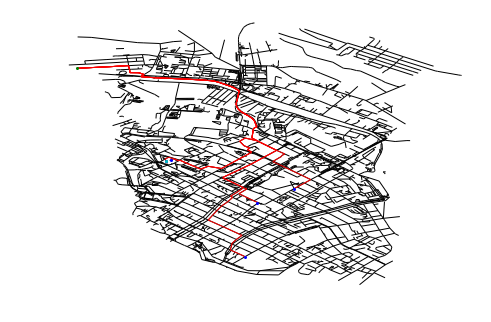

In [13]:
print('Введите ваши координаты (в промежутке [(48.4554053, 135.0399018),(48.5055174, 135.1392976)]):')
us_c1 = float(input())
us_c2 = float(input())
user_coord = [us_c1, us_c2]
near_node = nearNode(coord,user_coord,countList)
ind_near_node = countList.index(near_node)
[weight,path] = Dijkstra(len(adList),ind_near_node,matrix)
#[w, path]=A(ind_near_node,countList.index(objnodes[0]),matrix,[coord[i] for i in countList])
min_weight = float('inf');
min_node = 0
for node in objnodes:
    ind = countList.index(node)
    if weight[ind] < min_weight:
        min_weigt = weight[ind]
        min_node = node
edges = pathFinder(countList, path, ind_near_node, [countList.index(node) for node in objnodes])
plotGraph2(filename, coord, edges, objnodes, min_node)